In [1]:
import torch

# Dataset

In [2]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [3]:
data = pd.read_csv('../data/fitbit_apr/heartrate_seconds_merged.csv')
data

,Id,Time,Value
0,2022484408,4/12/2016 7:21:00 AM,97
1,2022484408,4/12/2016 7:21:05 AM,102
2,2022484408,4/12/2016 7:21:10 AM,105
3,2022484408,4/12/2016 7:21:20 AM,103
4,2022484408,4/12/2016 7:21:25 AM,101
...,...,...,...
2483653,8877689391,5/12/2016 2:43:53 PM,57
2483654,8877689391,5/12/2016 2:43:58 PM,56
2483655,8877689391,5/12/2016 2:44:03 PM,55
2483656,8877689391,5/12/2016 2:44:18 PM,55


In [4]:
data.Time = pd.to_datetime(data.Time)

In [5]:
hr = data.loc[(data.Id == data.Id.unique()[0]) & (data.Time < '2016-04-13')]

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, value_col='Value', time_col='Time', 
                 interval_value=5, interval_unit='s', interpolation_limit=11,
                 kernel_size=512, stride=512, missing_thresh=0.5):
        self.data = data
        self.value_col = value_col
        self.time_col = time_col
        self.data[self.time_col] = pd.to_datetime(self.data[self.time_col])
        self.data = self._construct_dataset(interval_value, interval_unit, interpolation_limit)

        self.seqs = []
        self.masks = []
        self.times = []
        self._create_seq(kernel_size, stride, missing_thresh)

    def _construct_dataset(self, interval_value, interval_unit, interpolation_limit):
        '''Reindexes data using pd.date_range with a frequency of interval_value interval_unit.
        Interpolates data with a limit of interpolation_limit'''
        df = self.data.copy()
        df = df.set_index(self.time_col)
        
        # Create time index with interval
        min_time = df.index.min()
        max_time = df.index.max()
        new_time_index = pd.date_range(min_time, max_time, freq=str(interval_value)+interval_unit)

        # Reindex with new time index
        reindex_df = df.reindex(new_time_index, method='nearest', tolerance=pd.Timedelta(interval_value-1, unit=interval_unit))

        # Reset index
        reindex_df.reset_index(inplace=True)
        reindex_df.rename(columns={'index': self.time_col}, inplace=True)

        return reindex_df.reset_index(drop=True).interpolate(limit=interpolation_limit)
    
    def _create_seq(self, kernel_size, stride, missing_thresh):
        df = self.data
        data_len = len(df)
        for i in range(0, data_len, stride):
            seq = df[self.value_col][i:i+kernel_size]
            time = df[self.time_col][i:i+kernel_size]
            if seq.isna().mean() <= missing_thresh:
                self.seqs.append(np.array(seq))
                self.masks.append(np.array(seq.notna()))
                self.times.extend(list(time))

    def __len__(self):
        return len(self.seqs)
    
    def __getitem__(self, idx):
        seq = torch.tensor(self.seqs[idx], dtype=torch.float32)
        return seq, self.masks[idx]

In [7]:
dataset = TimeSeriesDataset(hr)

C:\Users\user\AppData\Local\Temp\ipykernel_37132\3353180224.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.time_col] = pd.to_datetime(self.data[self.time_col])


In [8]:
dataset.__len__()

17

# Model

In [9]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={"task_name": "reconstruction"},  # For anomaly detection, we will load MOMENT in `reconstruction` mode
    local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

c:\Users\user\Desktop\Sputnik\2023-\CS50\health-app\env\Lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\user\Desktop\Sputnik\2023-\CS50\health-app\env\Lib\site-packages\huggingface_hub\hub_mixin.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

In [10]:
model

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

In [11]:
dataloader = DataLoader(dataset, batch_size=dataset.__len__()-1, drop_last=True)
x, mask = next(iter(dataloader))
x, mask

(tensor([[ 97.0000, 102.0000, 105.0000,  ...,  75.0000,  78.0000,  81.0000],
         [ 83.0000,  83.0000,  78.0000,  ...,  62.0000,  62.0000,  62.0000],
         [ 62.0000,  62.0000,  62.0000,  ...,  58.5000,  58.0000,  58.0000],
         ...,
         [ 67.0000,  67.0000,  67.0000,  ...,  81.0000,  81.0000,  81.5000],
         [ 82.0000,  80.0000,  80.0000,  ...,  89.0000,  89.0000,  89.0000],
         [ 89.0000,  89.0000,  88.0000,  ...,  83.0000,  82.0000,  80.0000]]),
 tensor([[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]))

In [12]:
x = x[:, None, :]
x.shape

torch.Size([16, 1, 512])

In [13]:
with torch.no_grad():
    output = model(x_enc=x, input_mask=mask)

In [14]:
preds = output.reconstruction.squeeze().numpy().flatten()
trues = x.squeeze().numpy().flatten()
anomaly_scores = np.abs(trues - preds) / preds * 100

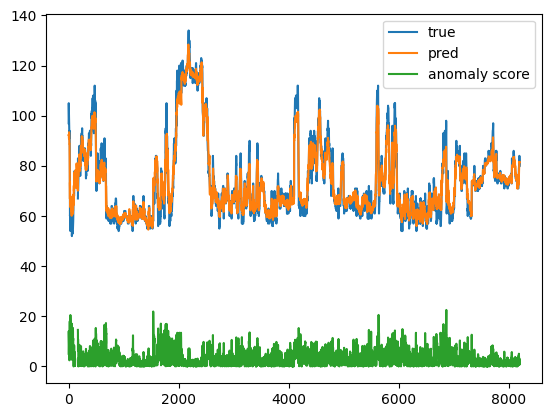

In [15]:
import matplotlib.pyplot as plt

plt.plot(trues, label='true')
plt.plot(preds, label='pred')
plt.plot(anomaly_scores, label='anomaly score')
plt.legend()

In [16]:
anomalies = pd.DataFrame({'time': dataset.times[:len(trues)],
                          'trues': trues, 'preds': preds, 'anomaly': anomaly_scores})
anomalies

,time,trues,preds,anomaly
0,2016-04-12 07:21:00,97.0,92.313683,5.076515
1,2016-04-12 07:21:05,102.0,92.283150,10.529387
2,2016-04-12 07:21:10,105.0,92.038277,14.082972
3,2016-04-12 07:21:15,104.0,92.177383,12.825940
4,2016-04-12 07:21:20,103.0,92.048088,11.898033
...,...,...,...,...
8187,2016-04-12 19:25:55,81.0,81.490593,0.602024
8188,2016-04-12 19:26:00,84.0,81.420998,3.167491
8189,2016-04-12 19:26:05,83.0,81.576309,1.745226
8190,2016-04-12 19:26:10,82.0,81.296165,0.865766


In [17]:
anomalies['is_anomaly'] = anomalies.anomaly > 15

In [18]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomalies.time, y=anomalies.trues,
                    mode='lines+markers',
                    name='heart rate'))
fig.add_trace(go.Scatter(x=anomalies.loc[anomalies.is_anomaly, 'time'], 
                            y=anomalies.loc[anomalies.is_anomaly, 'trues'],
                    mode='markers',
                    name='anomaly'))
fig.update_layout(showlegend=False)
fig.show()

In [19]:
anomalies.query("anomaly > 15")

,time,trues,preds,anomaly,is_anomaly
20,2016-04-12 07:22:40,89.000000,76.928635,15.691641,True
21,2016-04-12 07:22:45,86.000000,74.393372,15.601698,True
22,2016-04-12 07:22:50,83.000000,70.347916,17.985016,True
24,2016-04-12 07:23:00,60.000000,73.386742,18.241362,True
25,2016-04-12 07:23:05,60.500000,71.315727,15.165977,True
32,2016-04-12 07:23:40,54.000000,67.933701,20.510735,True
33,2016-04-12 07:23:45,54.500000,67.713348,19.513653,True
34,2016-04-12 07:23:50,55.000000,67.641228,18.688643,True
35,2016-04-12 07:23:55,56.500000,67.343155,16.101347,True
59,2016-04-12 07:25:55,52.000000,62.688614,17.050327,True


# Anomalies

In [10]:
def get_anomalies(data, model, anomaly_thresh=20):
    dataset = TimeSeriesDataset(data)
    batch_size = dataset.__len__() - 1
    dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True)
    x, mask = next(iter(dataloader))
    x = x[:, None, :]

    with torch.no_grad():
        output = model(x_enc=x, input_mask=mask)

    preds = output.reconstruction.squeeze().numpy().flatten().astype('float64')
    trues = x.squeeze().numpy().flatten().astype('float64')
    anomaly_scores = np.abs(trues - preds) / preds * 100

    anomalies = pd.DataFrame({'time': dataset.times[:len(trues)],
                              'trues': trues.round(1), 
                              'preds': preds.round(1), 
                              'anomaly': anomaly_scores.round(1)})
    return anomalies.query("anomaly > @anomaly_thresh")

In [11]:
get_anomalies(hr, model)

C:\Users\user\AppData\Local\Temp\ipykernel_50628\3353180224.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.time_col] = pd.to_datetime(self.data[self.time_col])


,time,trues,preds,anomaly
32,2016-04-12 07:23:40,54.0,67.9,20.5
1536,2016-04-12 09:29:00,58.0,74.3,21.9
1537,2016-04-12 09:29:05,58.0,74.1,21.7
5630,2016-04-12 15:52:50,69.0,86.9,20.6
6860,2016-04-12 17:35:20,96.0,79.0,21.5
...,...,...,...,...
58486,2016-04-19 09:28:10,93.0,75.5,23.2
63484,2016-04-19 16:24:40,152.0,124.7,21.9
63485,2016-04-19 16:24:45,154.0,124.1,24.1
63486,2016-04-19 16:24:50,155.0,122.7,26.3
